In [1]:
#### Import Packages ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [ ]:
#### Data Prep ####

# Load data
df = pd.read_csv('mta_data.csv', sep='\t')

# Rename columns, removing spaces to make this easier to work with later on
column_mapping = {
    'additional platform time': 'additional_platform_time',
    'additional train time': 'additional_train_time',
    'customer journey time performance': 'customer_journey_time_performance'
}
df = df.rename(columns=column_mapping)

In [3]:
#### Feature Engineering ####

# Creating new features that may be useful for our model
df['total_additional_time'] = df['additional_platform_time'] + df['additional_train_time']
df['apt_per_passenger'] = df['total_apt'] / df['num_passengers']
df['att_per_passenger'] = df['total_att'] / df['num_passengers']
df['month_num'] = pd.to_datetime(df['month']).dt.month
df['year'] = pd.to_datetime(df['month']).dt.year
df['high_performance'] = df['customer_journey_time_performance'] >= 0.90

# Function to create new categorical column 'performance_class', based on train journey performance
def PerformanceClass(x):
    if x >= 0.9:
        return 0
    elif x >= 0.8:
        return 1
    else:
        return 2

# Apply PerformanceClass() to our data
df['performance_class'] = df['customer_journey_time_performance'].apply(PerformanceClass)

We saw in our regression analysis that not all of our features may be sufficient to model our data, so we create new ones which may be helpful. In particular, 'high_performance' (binary) and 'performance_class' (multi-class) will be used as the response variable for our binary and multi-classification models, respectively.

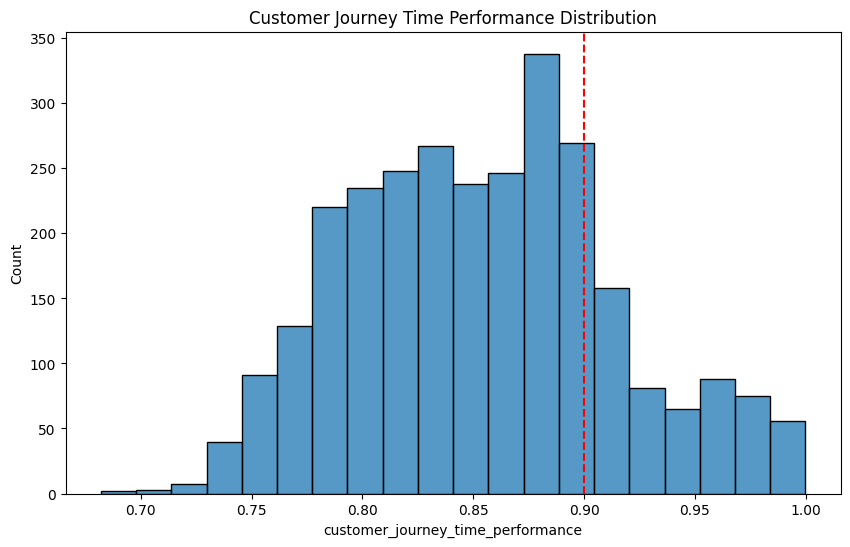

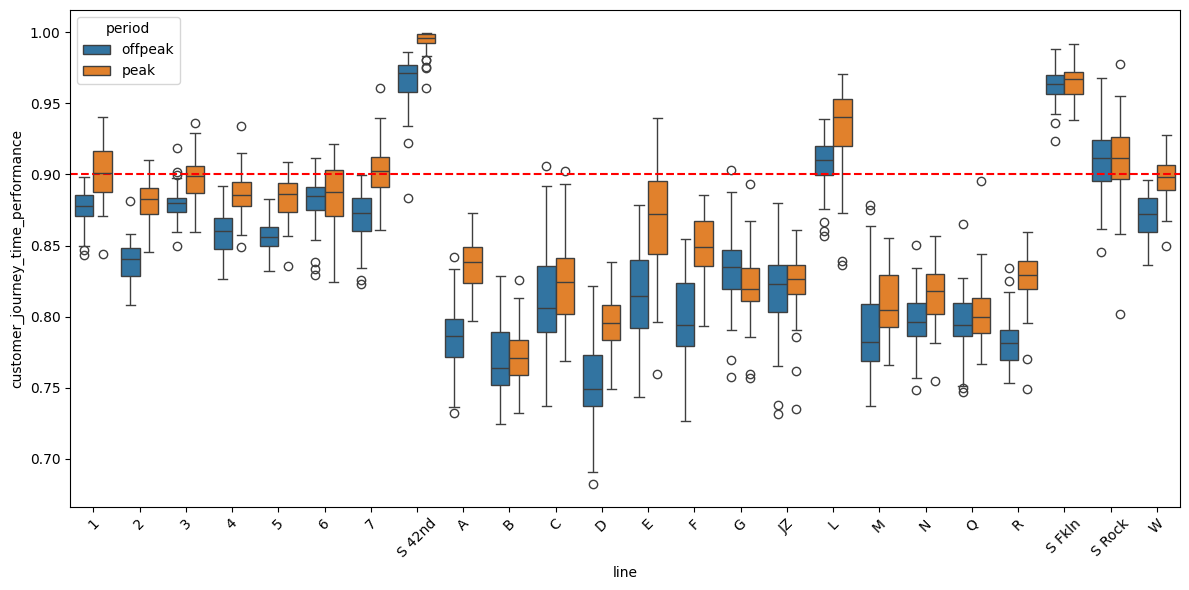

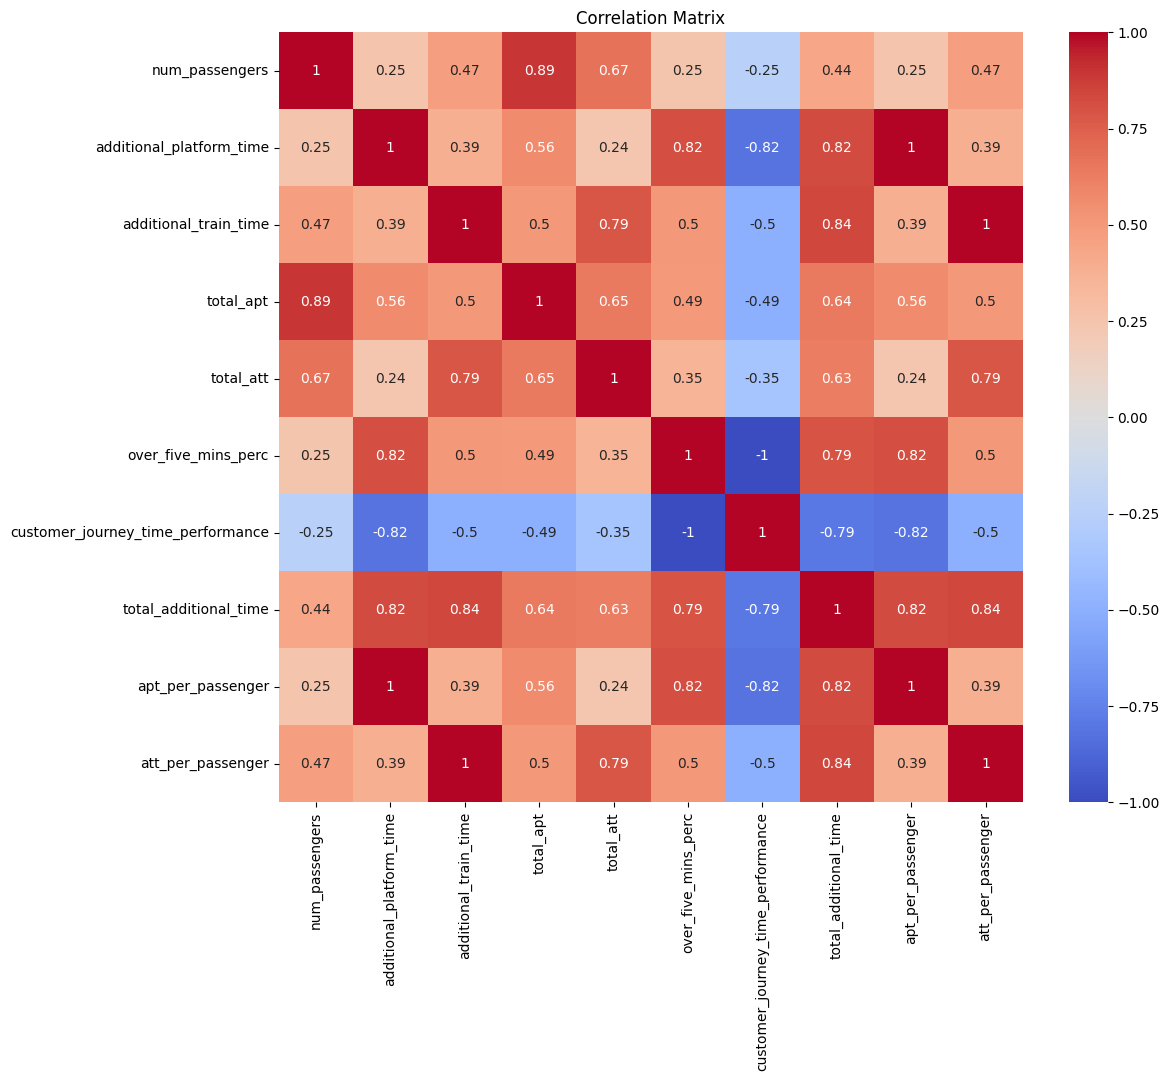

In [4]:
#### Plots ####

# Get histogram of train customer_journey_time_performance
# Add visiaul aid vertical line at 0.9
plt.figure(figsize=(10, 6))
sns.histplot(df['customer_journey_time_performance'], bins=20)
plt.axvline(0.9, color='red', linestyle='--')
plt.title('Customer Journey Time Performance Distribution')
plt.savefig('cjtp_distribution.png', dpi=300)
plt.show()

# Get box plot of train performance broken out by line and peak vs. offpeak
# Add visiaul aid horizontal line at 0.9
plt.figure(figsize=(12, 6))
sns.boxplot(x='line', y='customer_journey_time_performance', hue='period', data=df)
plt.axhline(0.9, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplot_performance.png', dpi=300)
plt.show()

# Get correlation matrix of our continuous features
numeric_cols = ['num_passengers', 'additional_platform_time', 'additional_train_time', 'total_apt', 'total_att',
                'over_five_mins_perc', 'customer_journey_time_performance', 'total_additional_time',
                'apt_per_passenger', 'att_per_passenger']
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()



We see that the distribution of customer_journey_time_performance is generally normally distributed, with a small tilt towards right-tailed.

Our boc plot shows that during peak service times trains are generally better performing, with a majority of lines fallign under a 90% rate. Importantly, we see a clear distinction between A Division trains (lines 1-7) and B Divison trains (all other lines). This distinction is most likely the result of two factors. First, A Division trains are lighter and shorter, possibly leading to faster times and less chance of delays. This is reflected in the general higher performance metrics.

The second distinction stems from how our data was collected. The data for A Division trains is collected by very different means from the B Division. A Division trains use a much newer and more robust system of determining train arrival and departure times from both platforms and spots on the route. In contrast, B Division data is collected from several different robust methods, and aggregated together. Not all systems can determine when a train has arrived or left a station, just that a switch is flipped. If, for example, a train partially leaves a station but stalls, the B Division system may record that the train has already left. Also, in the event of system errors, data is recorded by hand. All of  this can lead to severe differences in A Division and B Division data.

We build a model isolating each at the end of this analysis.

In [5]:
#### Data Prep ####

# Drop non-feature columns and isolate high_performance and performance_class to use in binary and multi-classification, respectively
X = df.drop(['month', 'high_performance', 'performance_class', 'customer_journey_time_performance'], axis=1)
y_binary = df['high_performance']
y_multi = df['performance_class']

# Isolate our categorical columns from the continuous columns
categorical_cols = ['division', 'line', 'period']
numerical_cols = ['num_passengers', 'additional_platform_time', 'additional_train_time', 'total_apt', 'total_att',
                  'over_five_mins', 'over_five_mins_perc', 'total_additional_time', 'apt_per_passenger',
                  'att_per_passenger', 'month_num', 'year']

# Create train and test datasets for binary and multi-classification
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi)


In [6]:
#### Preprocessing ####

# Create preprocessing pipeline and fit on X_train
preprocessor = Pipeline([
    ('one_hot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])
cat_preprocessor = preprocessor.fit(X_train[categorical_cols])

# Run OneHotEncoder() on categorical features to convert to numerical for both training and test data
cat_features_train = cat_preprocessor.transform(X_train[categorical_cols])
cat_features_test = cat_preprocessor.transform(X_test[categorical_cols])

# Combine numerical and categorical features
X_train_processed = np.hstack([X_train[numerical_cols].values, cat_features_train])
X_test_processed = np.hstack([X_test[numerical_cols].values, cat_features_test])


In [8]:
#### Feature Names ####

# Break out and construct new feature names
# Iterate over our categorical columns and the unique categories in each, using format {col}_{cat}
# For example, for 'line' feature, have feature names, 'line_1', 'line_2', etc., with all lines being broken out and named
feature_names = numerical_cols + [f"{col}_{cat}" for col, cats in zip(categorical_cols, cat_preprocessor.named_steps['one_hot'].categories_) for cat in cats[1:]]

Random Forest Binary:
Accuracy: 0.7797
              precision    recall  f1-score   support

       False       0.79      0.98      0.88       456
        True       0.00      0.00      0.00       116

    accuracy                           0.78       572
   macro avg       0.40      0.49      0.44       572
weighted avg       0.63      0.78      0.70       572



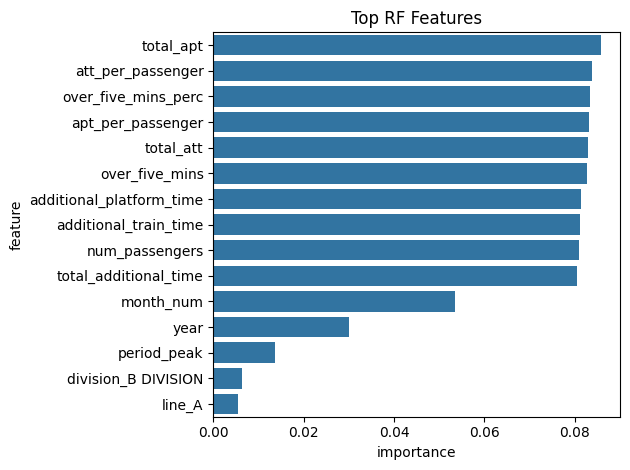

In [9]:
#### Random Forest - Binary ####

# Create random forest model for binary classification and fit to training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train_binary)

# Test model performance on X_test_processed and print accuracy results
rf_predictions = rf_model.predict(X_test_processed)
print("Random Forest Binary:")
print(f"Accuracy: {accuracy_score(y_test_binary, rf_predictions):.4f}")
print(classification_report(y_test_binary, rf_predictions))

# Get box plot ranking features by importance
rf_importance = pd.DataFrame({'feature': feature_names, 'importance': rf_model.feature_importances_})
rf_importance = rf_importance.sort_values(by='importance', ascending=False)
sns.barplot(data=rf_importance.head(15), x='importance', y='feature')
plt.title("Top RF Features")
plt.tight_layout()
plt.savefig('rf_feature_importance_binary.png', dpi=300)
plt.show()

XGBoost Binary:
Accuracy: 0.7972
              precision    recall  f1-score   support

       False       0.80      1.00      0.89       456
        True       0.00      0.00      0.00       116

    accuracy                           0.80       572
   macro avg       0.40      0.50      0.44       572
weighted avg       0.64      0.80      0.71       572



c:\Users\hotke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hotke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hotke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

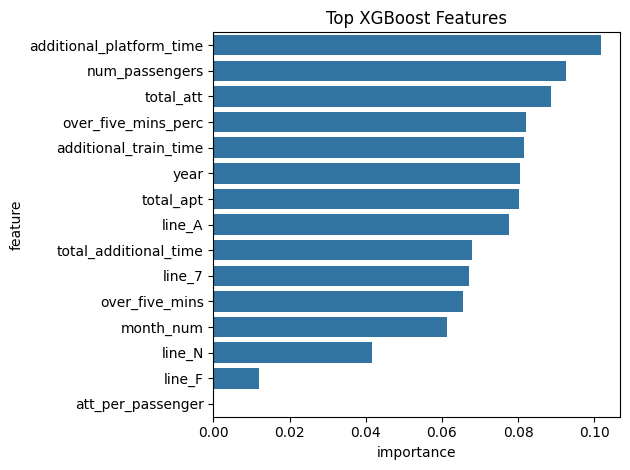

In [10]:
#### XGBoost - Binary ####

# Create XGBoost model for binary classification and fit to training data
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, early_stopping_rounds=10)
xgb_model.fit(X_train_processed, y_train_binary, eval_set=[(X_test_processed, y_test_binary)], verbose=0)

# Test model performance on X_test_processed and print accuracy results
xgb_predictions = xgb_model.predict(X_test_processed)
print("XGBoost Binary:")
print(f"Accuracy: {accuracy_score(y_test_binary, xgb_predictions):.4f}")
print(classification_report(y_test_binary, xgb_predictions))

# Get box plot ranking features by importance
xgb_importance = pd.DataFrame({'feature': feature_names, 'importance': xgb_model.feature_importances_})
xgb_importance = xgb_importance.sort_values(by='importance', ascending=False)
sns.barplot(data=xgb_importance.head(15), x='importance', y='feature')
plt.title("Top XGBoost Features")
plt.tight_layout()
plt.savefig('xgb_feature_importance_binary.png', dpi=300)
plt.show()

In [11]:
#### Random Forest - Multi-class ####

# Create Random Forest model for multi-class classification and fit to training data
rf_multi_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi_model.fit(X_train_processed, y_train_multi)

# Test model performance on X_test_processed and print accuracy results
rf_multi_predictions = rf_multi_model.predict(X_test_processed)
print("Random Forest Multi-class:")
print(f"Accuracy: {accuracy_score(y_test_multi, rf_multi_predictions):.4f}")
print(classification_report(y_test_multi, rf_multi_predictions))

Random Forest Multi-class:
Accuracy: 0.9965
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       116
           1       0.99      1.00      1.00       336
           2       1.00      1.00      1.00       120

    accuracy                           1.00       572
   macro avg       1.00      0.99      1.00       572
weighted avg       1.00      1.00      1.00       572



In [12]:
#### XGBoost - Multi-class ####

# Create XGBoost model for multi-class classification and fit to training data
xgb_multi_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, early_stopping_rounds=10)
xgb_multi_model.fit(X_train_processed, y_train_multi, eval_set=[(X_test_processed, y_test_multi)], verbose=0)

# Test model performance on X_test_processed and print accuracy results
xgb_multi_predictions = xgb_multi_model.predict(X_test_processed)
print("XGBoost Multi-class:")
print(f"Accuracy: {accuracy_score(y_test_multi, xgb_multi_predictions):.4f}")
print(classification_report(y_test_multi, xgb_multi_predictions))


XGBoost Multi-class:
Accuracy: 0.9965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       336
           2       0.99      0.99      0.99       120

    accuracy                           1.00       572
   macro avg       1.00      1.00      1.00       572
weighted avg       1.00      1.00      1.00       572



Summarizing the our results so far, we see that for the Random Forest model, the binary model gave us ~78% accuracy, while the multi-class model gave us ~100% accuracy. For the XGBoost model, the binary model gave us ~80% accuracy, while the multi-class gave us ~100% accuracy. The takeaway here is that while both models performed well, they had a much easier time predicting multiple classes, which makes sense given how much variation there can be between trains of each line and division.

Also, we see that the Random Forest and XGBoost models considered different features to be the most important. Our random forest model considered total_apt and att_per_passenger (generally, the amount of time a passenger waits for their train) as the most important features, while the XGBoost model assumed the number of passengers and the additional time a passenger spends on a train as the most importance. More analysis could be done here, but this demonstrates the importance of differenct perspectives on which of our features are important.

In [13]:
#### Hyperparameter Tuning ####

# Use GridSearchCV() to use cross-validation to perform exhaustive search of possible hyperparameters
# Use accuracy to evaluate performance of cross-validated model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train_binary)

# Print best parameters from GridSearchCV(), use them in new model, and give accuracy report
print("Best Params:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test_processed)
print(f"Best RF Accuracy: {accuracy_score(y_test_binary, best_rf_predictions):.4f}")
print(classification_report(y_test_binary, best_rf_predictions))

Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best RF Accuracy: 0.7937
              precision    recall  f1-score   support

       False       0.80      1.00      0.88       456
        True       0.00      0.00      0.00       116

    accuracy                           0.79       572
   macro avg       0.40      0.50      0.44       572
weighted avg       0.63      0.79      0.71       572



In [14]:
#### A Division-specific Random Forest Model ####
### Data for the A Division and B Division trains are collected via very different means. Therefore, we test independent models for each ### 

# Isolate observations where 'division' == 'A DIVISION'
# Create new training data
mask_a_div = X_train['division'] == 'A DIVISION'
a_train_idx = np.where(mask_a_div)[0]
X_train_a = X_train_processed[a_train_idx]
y_train_a = y_train_binary.iloc[a_train_idx]

# Isolate observations where 'division' == 'A DIVISION'
# Create new testing data
mask_a_div_test = X_test['division'] == 'A DIVISION'
a_test_idx = np.where(mask_a_div_test)[0]
X_test_a = X_test_processed[a_test_idx]
y_test_a = y_test_binary.iloc[a_test_idx]

# Train Random Forest model on new A Divsion training data and print accuracy report
if len(X_train_a) > 0 and len(X_test_a) > 0:
    rf_a_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_a_model.fit(X_train_a, y_train_a)
    rf_a_predictions = rf_a_model.predict(X_test_a)
    print("A Division RF:")
    print(f"Accuracy: {accuracy_score(y_test_a, rf_a_predictions):.4f}")
    print(classification_report(y_test_a, rf_a_predictions))
else:
    print("Not enough A Division data")

A Division RF:
Accuracy: 0.7120
              precision    recall  f1-score   support

       False       0.73      0.96      0.83       140
        True       0.25      0.04      0.07        51

    accuracy                           0.71       191
   macro avg       0.49      0.50      0.45       191
weighted avg       0.60      0.71      0.63       191



In [15]:
#### B Division-specific Random Forest Model ####

# Isolate observations where 'division' == 'B DIVISION'
# Create new training data
mask_b_div = X_train['division'] == 'B DIVISION'
b_train_idx = np.where(mask_b_div)[0]
X_train_b = X_train_processed[b_train_idx]
y_train_b = y_train_binary.iloc[b_train_idx]

# Isolate observations where 'division' == 'B DIVISION'
# Create new testing data
mask_b_div_test = X_test['division'] == 'B DIVISION'
b_test_idx = np.where(mask_b_div_test)[0]
X_test_b = X_test_processed[b_test_idx]
y_test_b = y_test_binary.iloc[b_test_idx]

# Train Random Forest model on new B Divsion training data and print accuracy report
if len(X_train_b) > 0 and len(X_test_b) > 0:
    rf_b_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_b_model.fit(X_train_b, y_train_b)
    rf_b_predictions = rf_b_model.predict(X_test_b)
    print("B Division RF:")
    print(f"Accuracy: {accuracy_score(y_test_b, rf_b_predictions):.4f}")
    print(classification_report(y_test_b, rf_b_predictions))
else:
    print("Not enough B Division data")

B Division RF:
Accuracy: 0.8268
              precision    recall  f1-score   support

       False       0.83      1.00      0.91       316
        True       0.00      0.00      0.00        65

    accuracy                           0.83       381
   macro avg       0.41      0.50      0.45       381
weighted avg       0.69      0.83      0.75       381



Our results for the separate A Division and B Division binary models give us generally the same accuracy as the combined model. We note that accuracy for the A Division is lower, but more analysis is needed to determine why.